これを真似しながらとりあえず動かしてみる。

https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608

In [1]:
!pip install --upgrade shap

Requirement already up-to-date: shap in /opt/conda/lib/python3.6/site-packages (0.30.2)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import shap
import eli5
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_formats = {'png', 'retina'}


shap.initjs()

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [4]:
Counter(labels)

Counter({0: 24720, 1: 7841})

In [5]:
data['Marital Status'].cat.codes.head() #category型ではこんなデータの持ち方をしているのでこれを直接エンコーダーに適応してしまおう

0    4
1    2
2    0
3    2
4    2
dtype: int8

In [6]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head() #leak気味なencodeになってしまうが今回はまあいいだろう

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_train.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,6,9.0,2,5,5,4,0,0.0,2179.0,12.0,39
1216,48.0,6,10.0,2,3,0,0,1,7688.0,0.0,40.0,39
27962,23.0,7,10.0,2,10,0,4,1,0.0,0.0,30.0,39


In [8]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,Self-emp-not-inc,9.0,Married-civ-spouse,Farming-fishing,Wife,White,Female,0.0,2179.0,12.0,United-States
1216,48.0,Self-emp-not-inc,10.0,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688.0,0.0,40.0,United-States
27962,23.0,State-gov,10.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States


In [9]:
import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [10]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

In [11]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test,
                                     predicted_labels=predictions,
                                     classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.76      0.67      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6972   483
        1        775  1539


古典的な feature importanceで xgboostを理解する

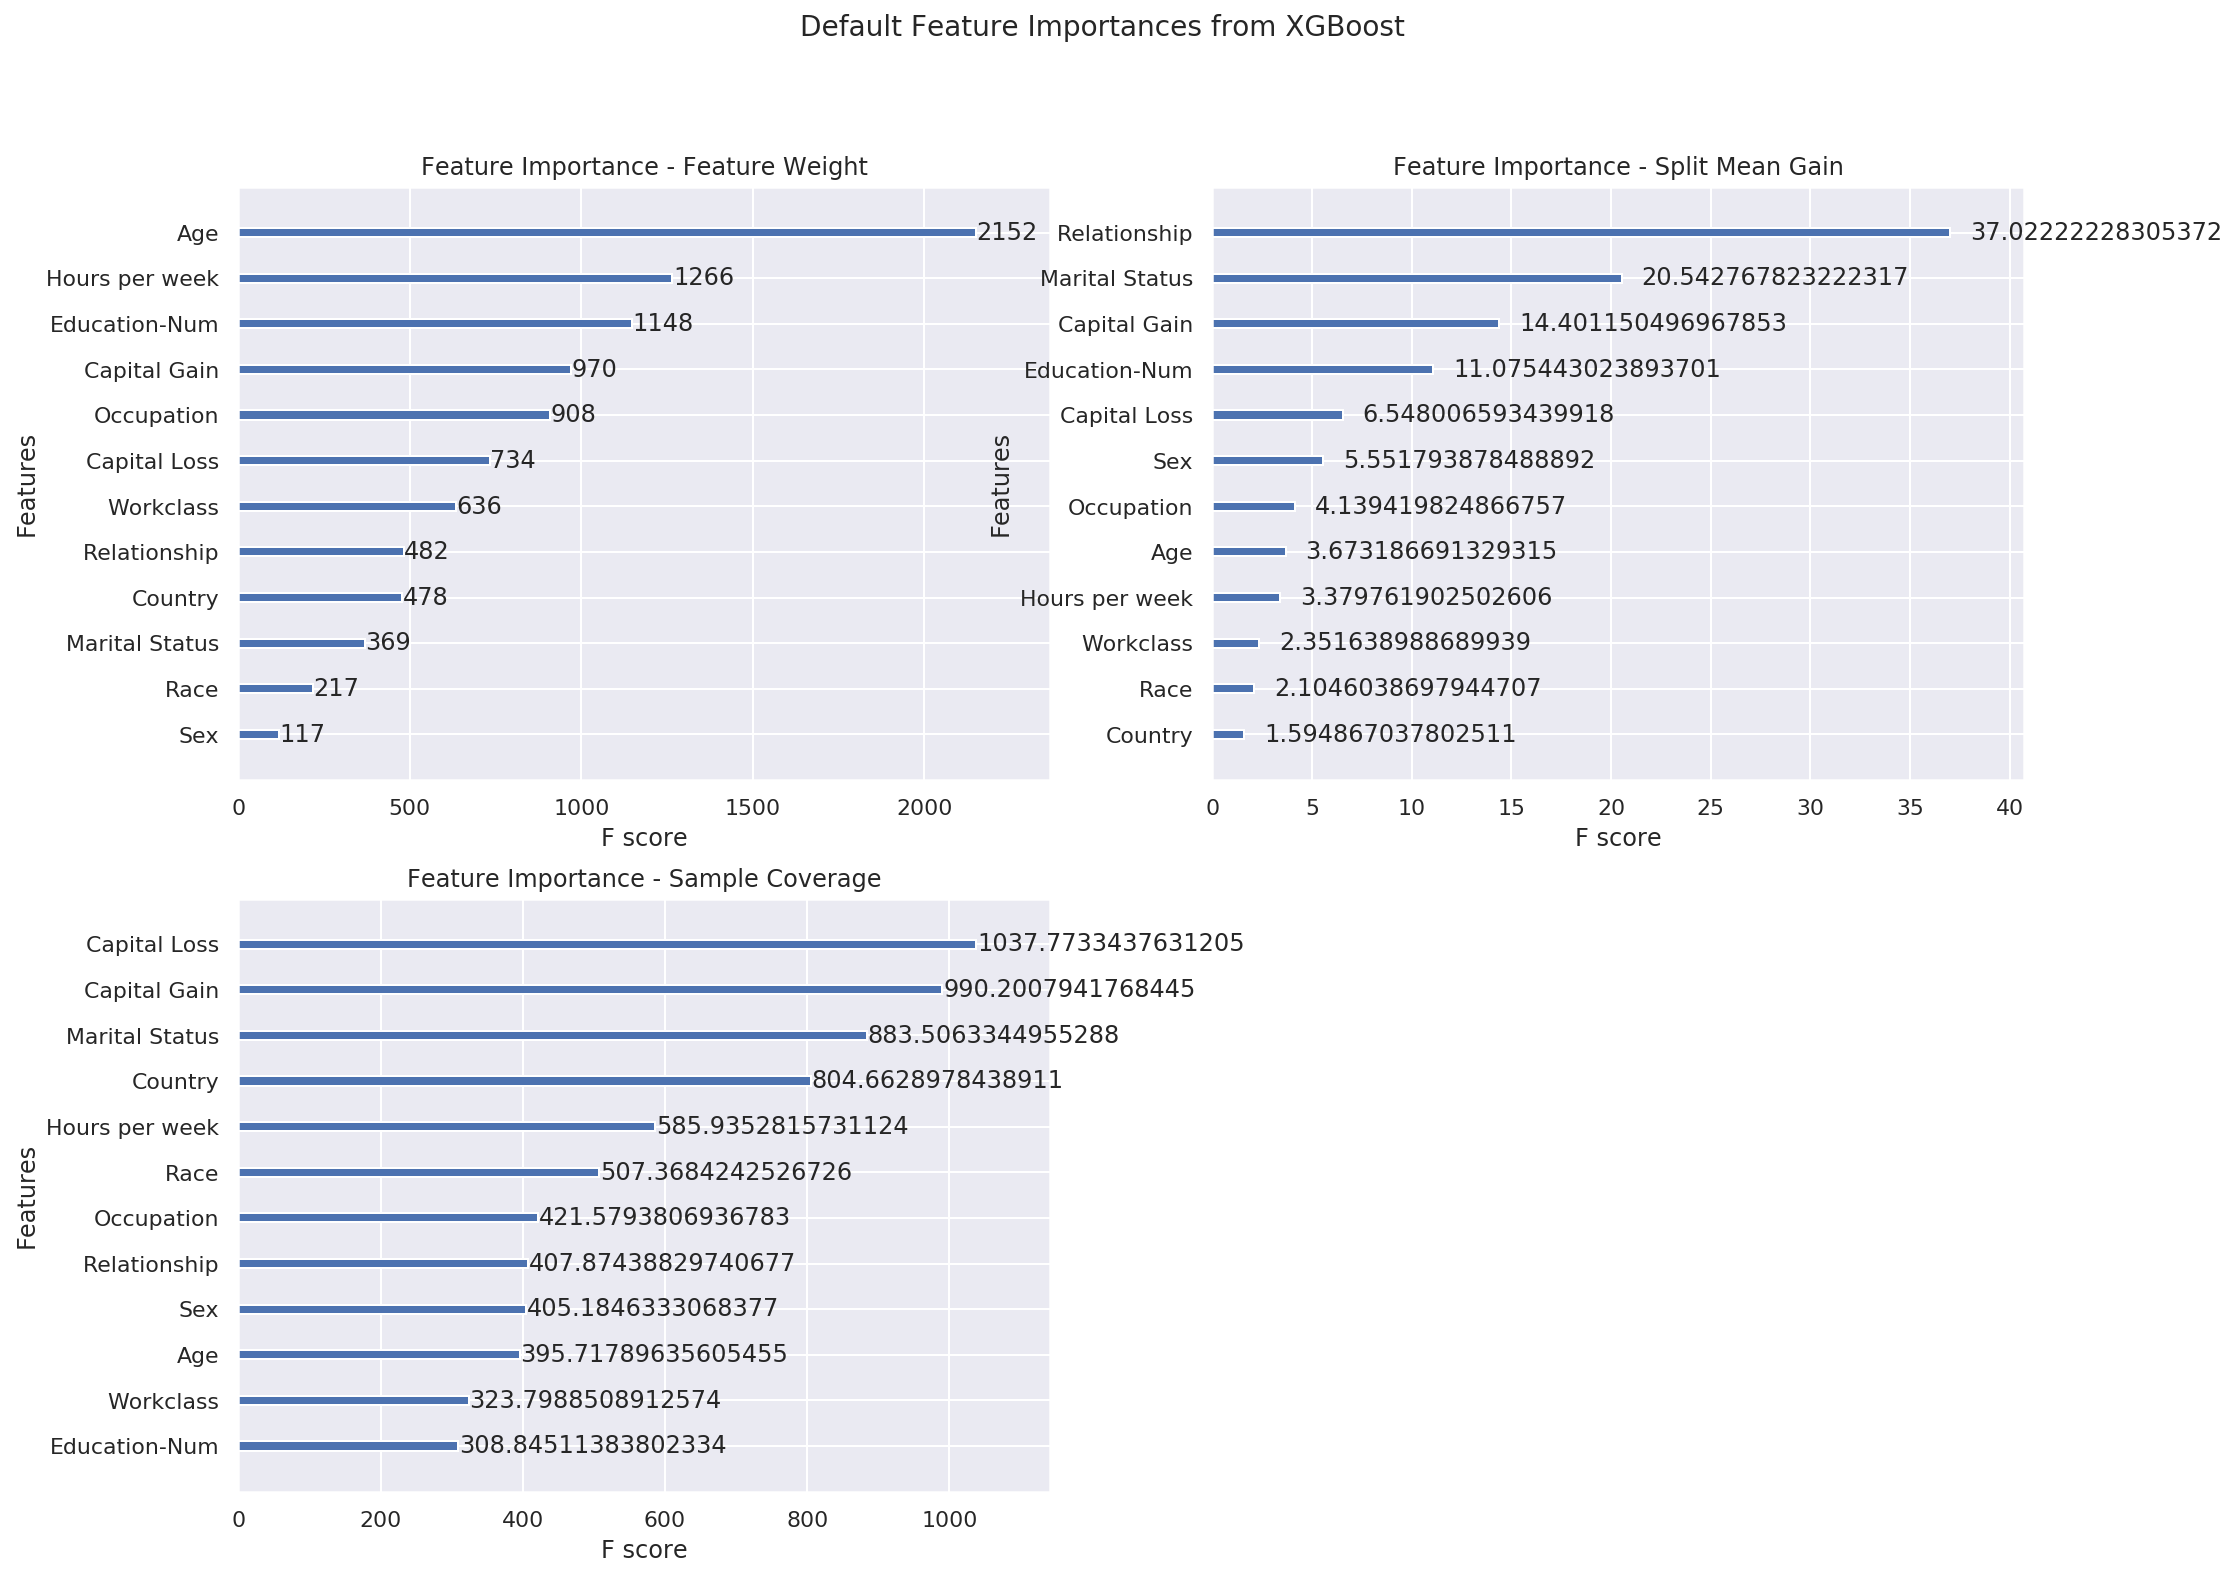

In [12]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

eli5ではどういうふうに出てくるのか？

In [13]:
eli5.show_weights(xgc.get_booster()) #各特徴量のgainの占める寄与への割合

Weight,Feature
0.3294,Relationship
0.1828,Marital Status
0.1281,Capital Gain
0.0985,Education-Num
0.0583,Capital Loss
0.0494,Sex
0.0368,Occupation
0.0327,Age
0.0301,Hours per week
0.0209,Workclass


In [14]:
# 単独の予測に対するcontribution (どうやって表示してるんだろう...)
# →木で最終的な予測決定に各特徴量がどうやって機能したのか計算しているらしい だからtreeモデルしか使えない方法
# limeと違って完全なブラックボックスではない
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns),
                     show_feature_values=True)

Actual Label: 0
Predicted Label: 0


In [15]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns), 
                     show_feature_values=True)

Actual Label: 1
Predicted Label: 1


skaterによるモデル解釈→skaterをインストールするとすべてが死ぬ

shapはどう？

ちなみにshapは本来計算に時間がかかるが、論文では木のアンサンブルでも十分計算が軽く済むように工夫をしている点が素晴らしいらしい

In [16]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head()

Expected Value: -1.3625857


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.209206,-0.003895,-0.073927,-1.078541,-0.645259,-0.517731,-0.002871,-0.421329,-0.144742,-0.036394,-0.568053,-0.004587
1,0.354368,-0.262398,-0.483883,0.586233,0.307967,1.194750,0.017408,-0.216272,-0.108322,-0.048158,-0.095782,0.017657
2,-0.525650,0.030637,0.970991,0.360480,0.528695,0.603971,-0.103895,0.050630,-0.176231,-0.087669,0.509656,0.024573
3,-0.426095,0.076188,0.576406,-1.108961,-0.517884,-0.522604,0.028896,-0.359870,-0.142805,-0.057430,-0.250736,0.023183
4,-0.503867,-0.159754,-0.129339,-0.547773,-0.049194,-0.414065,-0.019701,0.128197,-3.685364,-0.031033,0.781617,0.001285


In [17]:
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test_disp.iloc[0,:])

In [18]:
shap.force_plot(explainer.expected_value, 
                shap_values[2,:], X_test_disp.iloc[2,:])

In [19]:
shap.force_plot(explainer.expected_value, 
                shap_values[:100,:], X_test_disp.iloc[:100,:])
#おもしろ

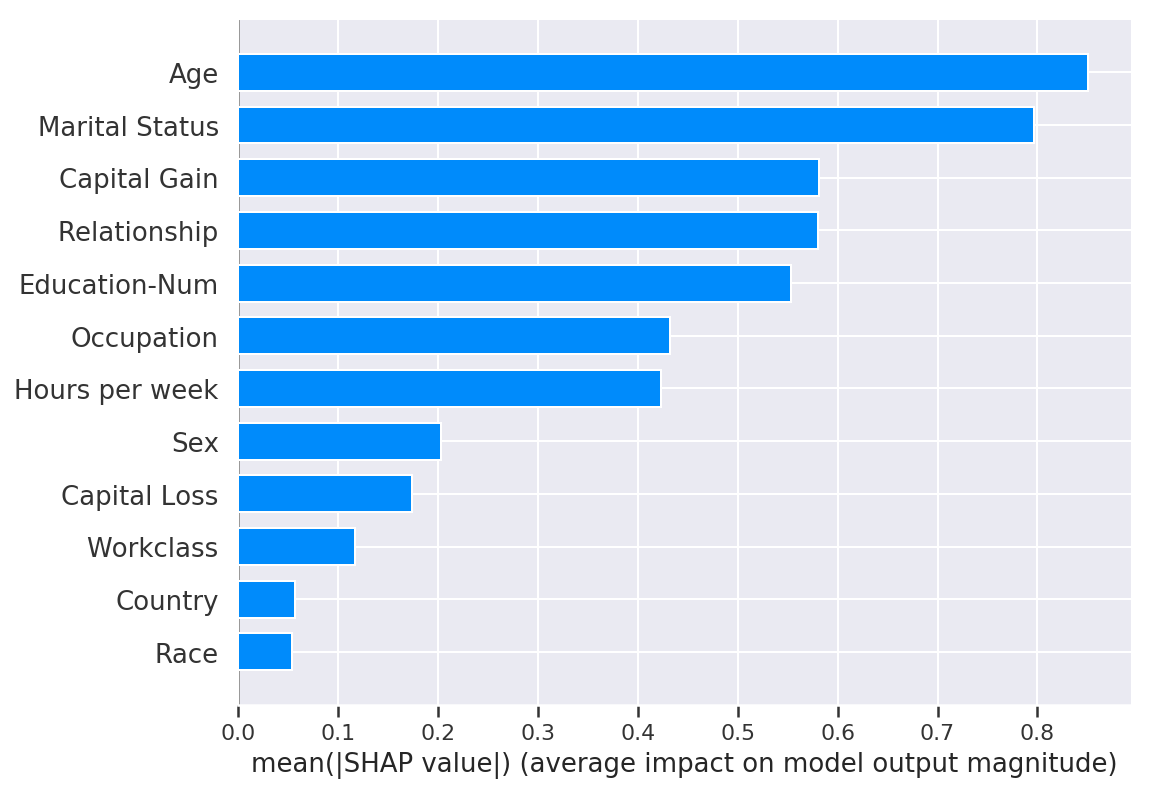

In [20]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

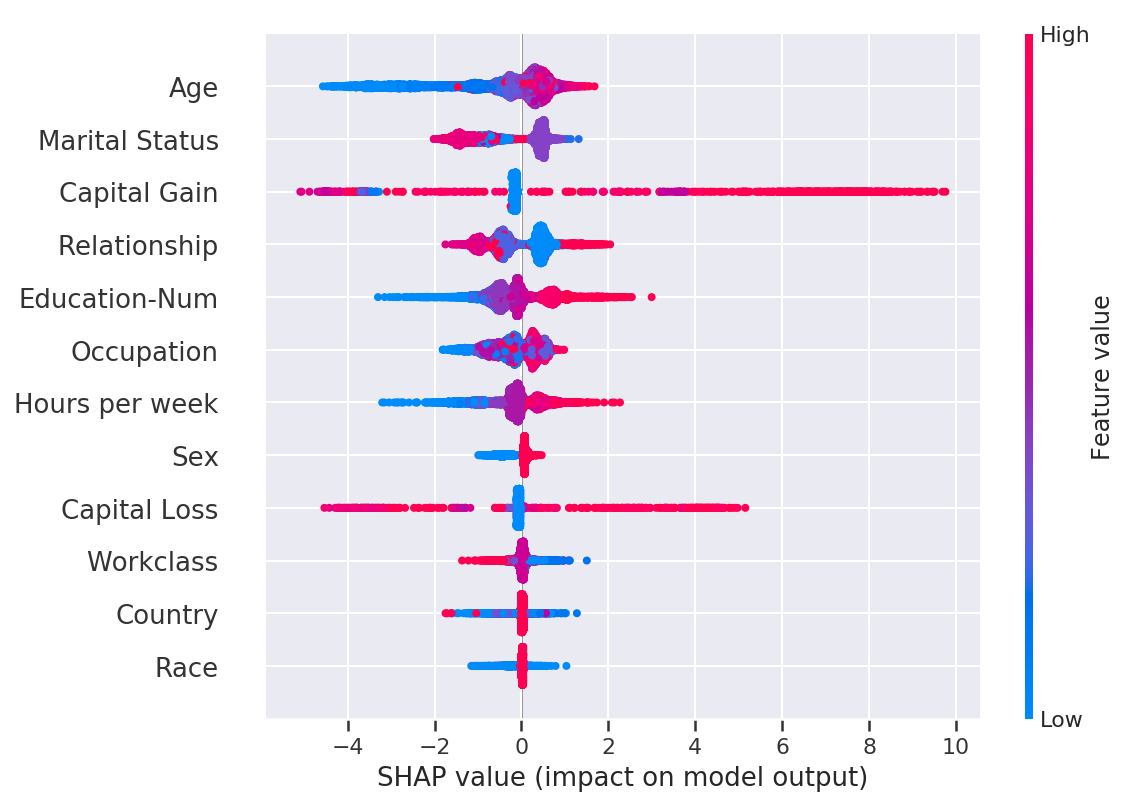

In [21]:
shap.summary_plot(shap_values, X_test)

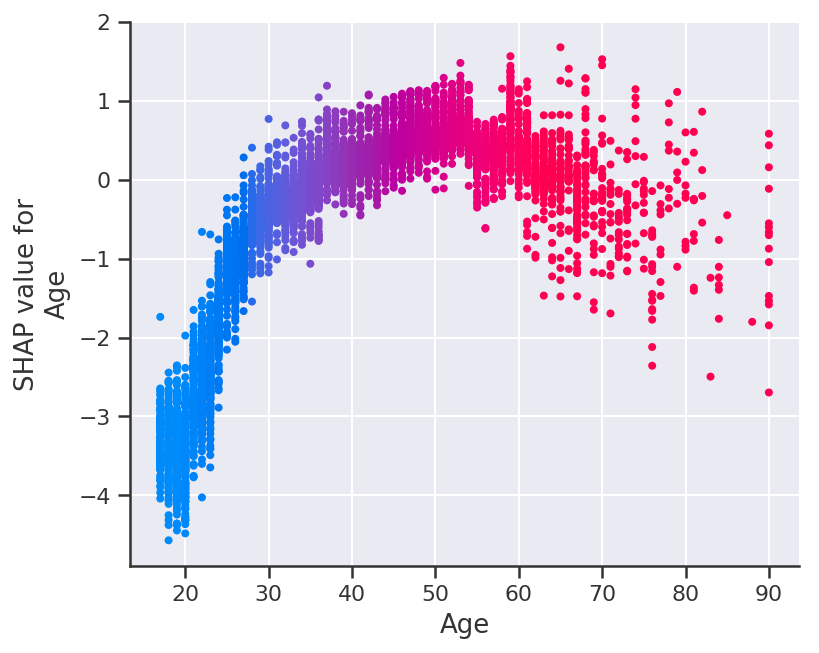

In [22]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

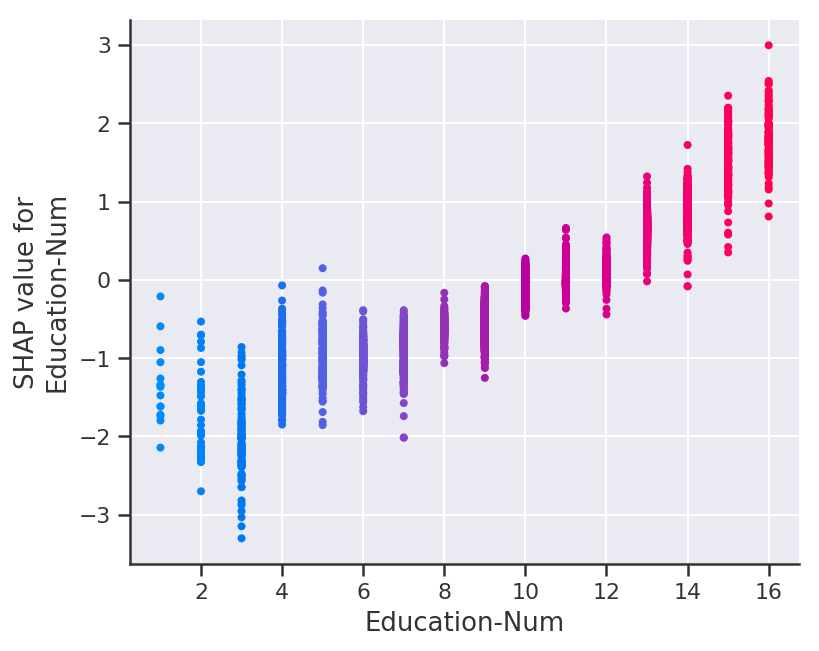

In [23]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

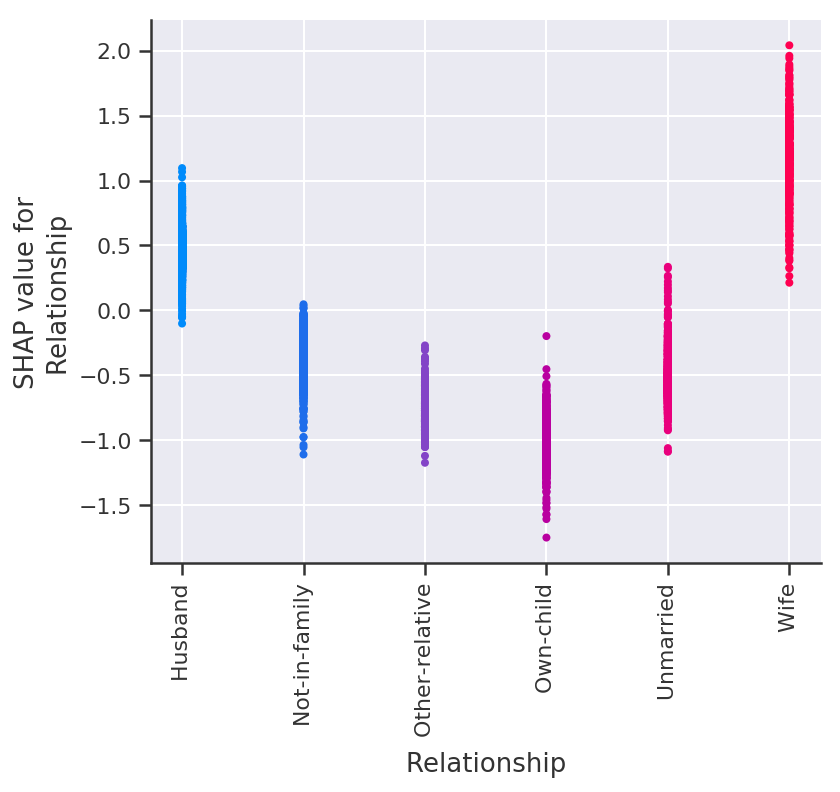

In [24]:
shap.dependence_plot(ind='Relationship', interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

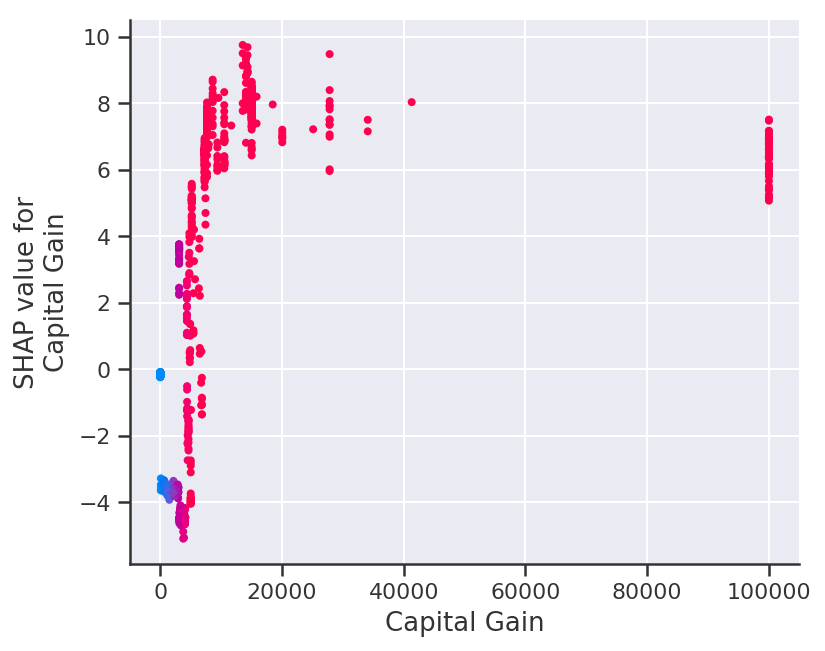

In [25]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

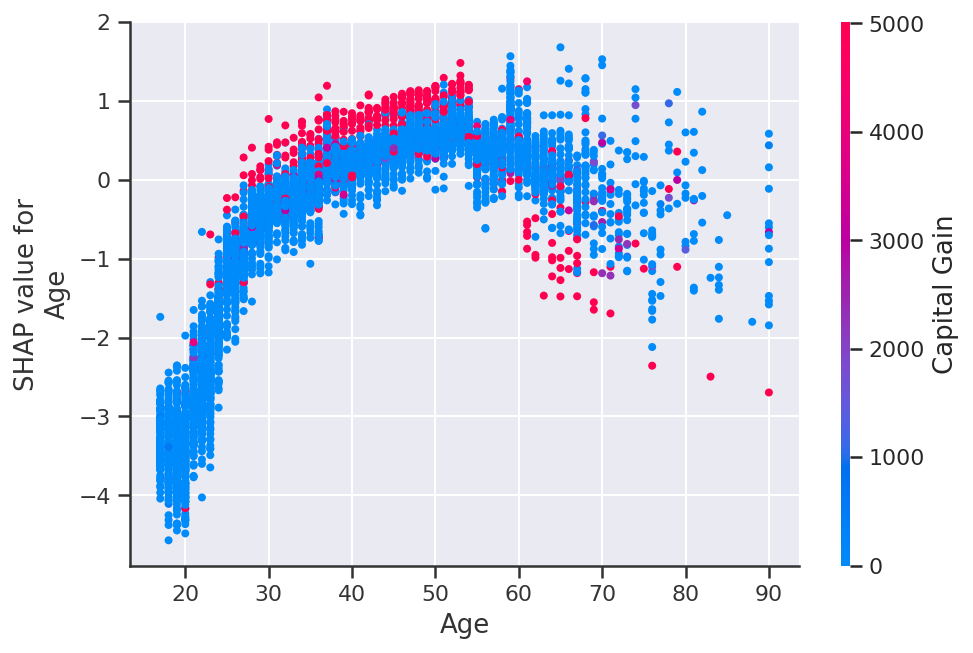

In [26]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

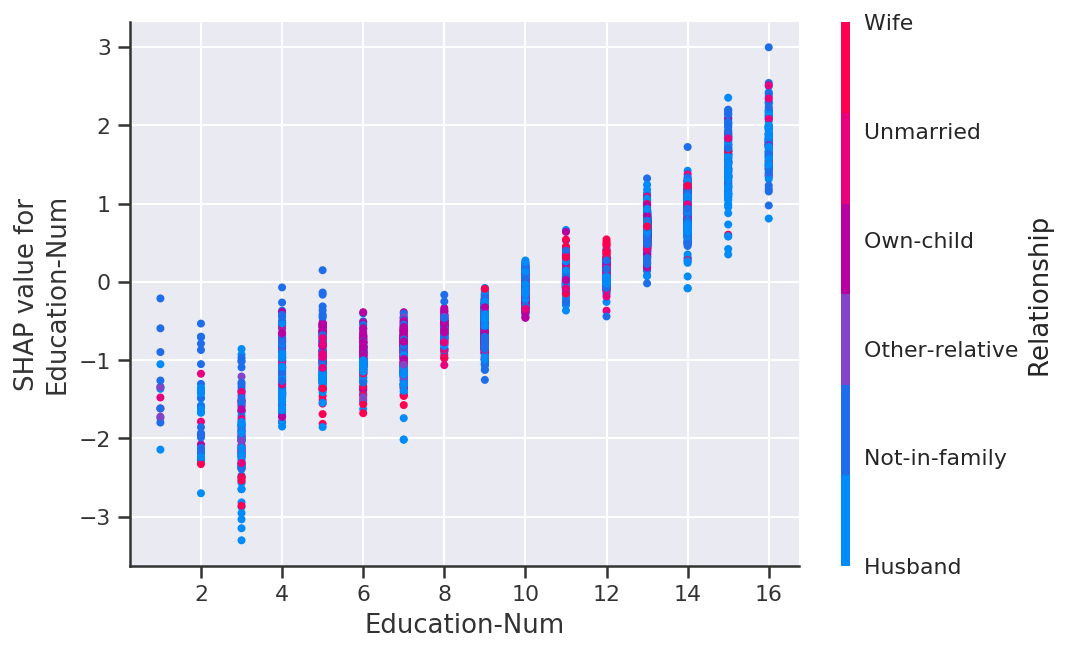

In [27]:
shap.dependence_plot(ind='Education-Num', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

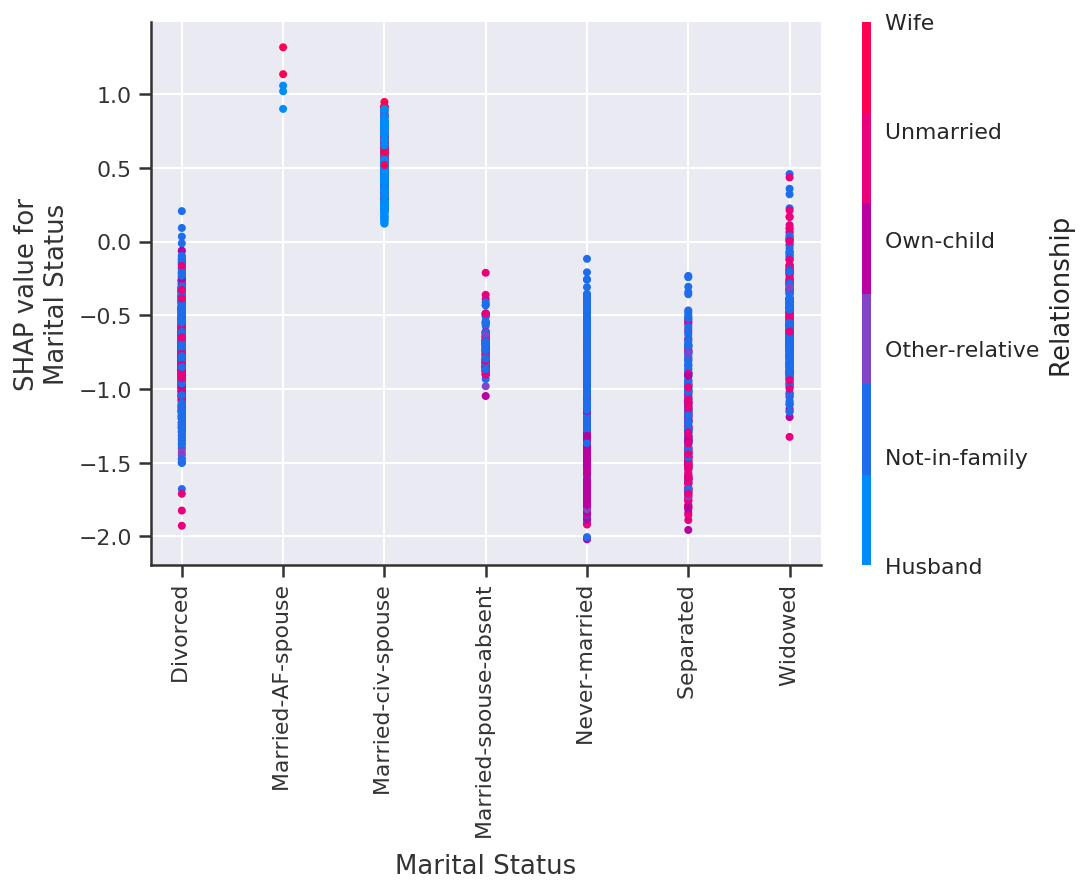

In [28]:
shap.dependence_plot(ind='Marital Status', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

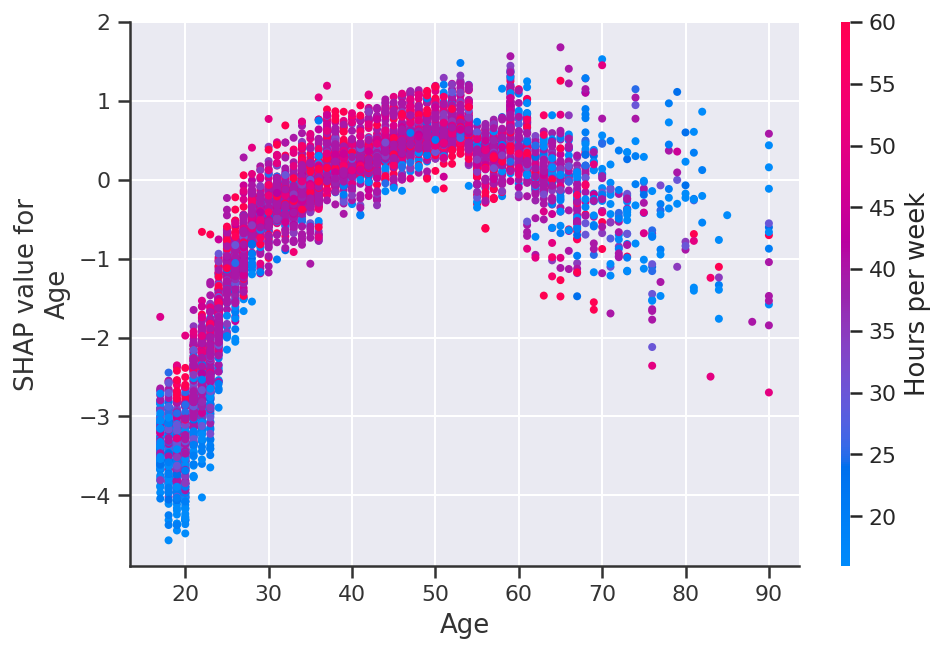

In [29]:
shap.dependence_plot(ind='Age', interaction_index='Hours per week', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

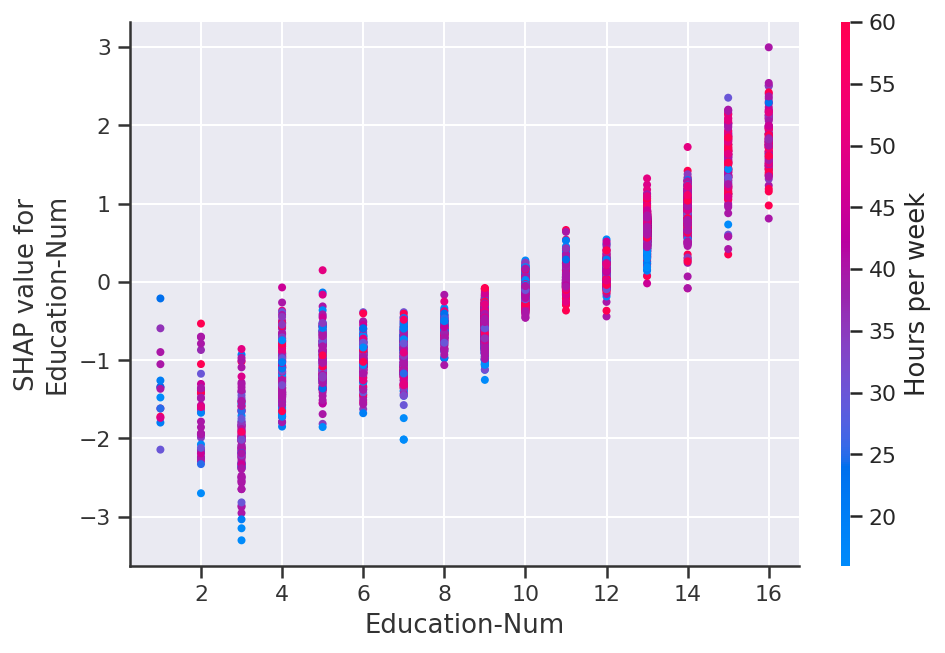

In [30]:
shap.dependence_plot(ind='Education-Num', interaction_index='Hours per week', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)